### MixUp

In [1]:
from PIL import Image
import os
from random import randint
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_folder = 'images/val2014/'
imgs = os.listdir(img_folder)
batch_x = [Image.open(img_folder + p).resize((224,224)) for p in imgs[10:20]] #这行代码从文件夹中读取第10到第19个图像文件，并将它们调整为 224x224 的大小，存储在 batch_x 列表中

FileNotFoundError: [Errno 2] No such file or directory: 'images/val2014/'

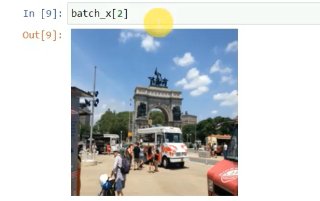

正如你所看到的，这是一些图片来自 COCO 验证集。我将避免使用 c4因为图像确实很模糊。
所以我只会处理 COCO 图像，否则我就可以研究 ImageNet，但是很大很昂贵

In [ ]:
def normalize_image(x): #将输入图像 x 归一化。首先将图像的像素值除以最大值，然后减去均值并除以标准差
    x = x / np.max(x) # change range not 0-255 but 0 to 1 我们如何做到这一点呢？我们除以最大值，在这种情况下，即 255。因此像素值为 255 将变为 1，像素值为 0 的像素将变为 0。因此你将得到一系列像素值介于 0 和 1 之间。
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (x - mean) / std #然后我要从图像中减去平均值并除以标准差。这是我们之前看到的规范化技术

In [ ]:
def denormalize_image(x): #将归一化的图像 x 反归一化。首先乘以标准差并加上均值，然后将像素值裁剪到 [0, 1] 范围内
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = std * x + mean
    x = np.clip(x, 0, 1)
    return x

In [ ]:
lam = 0.7 #混合系数
batch_size = len(batch_x)#批次大小
current_image = normalize_image(np.array(batch_x[0])) #归一化第一个图像, 将两个图像混合, 这里的例子就选择了第一张图像 和 另一张随机图像index下的图像
random_index = randint(0, batch_size - 1)
random_image_from_batch = normalize_image(np.array(batch_x[random_index])) #随机选择一个图像索引 random_index 并归一化该图像

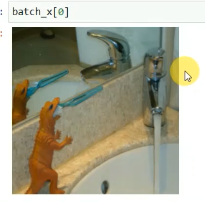

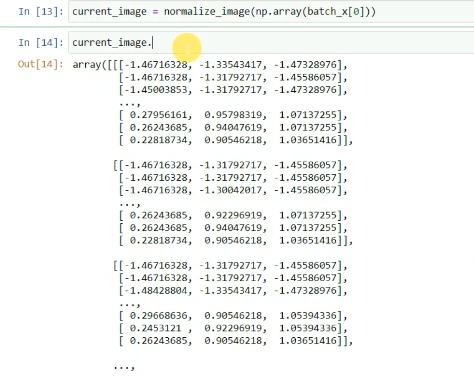

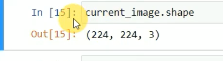

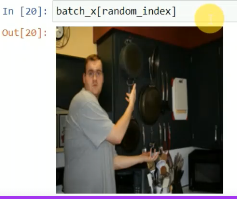




In [3]:
plt.imshow(denormalize_image(current_image)) #显示反归一化后的 current_image，并关闭坐标轴
plt.axis("off")

NameError: name 'denormalize_image' is not defined

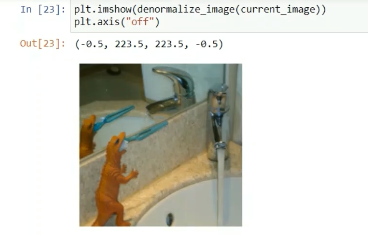

In [ ]:
plt.imshow(denormalize_image(random_image_from_batch)) #显示反归一化后的 random_image_from_batch，并关闭坐标轴
plt.axis("off")

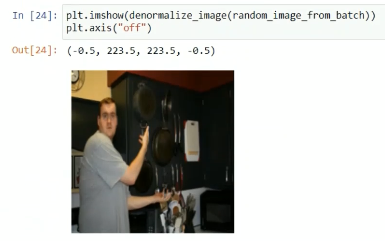

In [ ]:
mixed_image = lam * current_image + (1 - lam) * random_image_from_batch # 混合图像的公式

In [ ]:
plt.imshow(denormalize_image(mixed_image)) #显示反归一化后的 mixed_image，并关闭坐标轴
plt.axis("off")
#因此，我们将只采用混合图像,并对其进行非规范化，因为我们想看到它，我们想将其可视化，并且必须将其非规范化

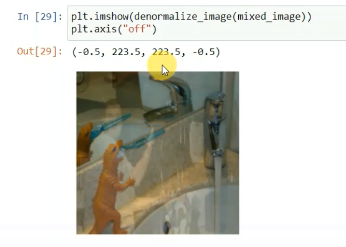

Loss = λ* XE(pred, y_a) + (1 - λ) * XE(pred, y_b)

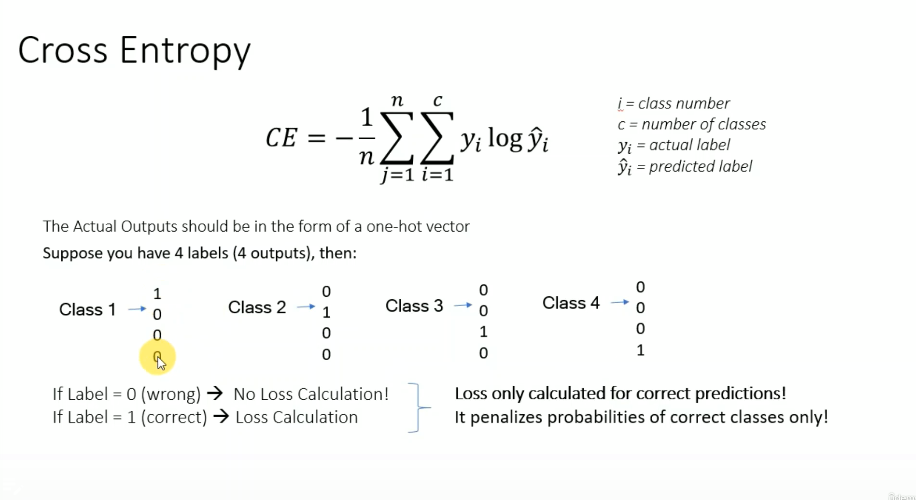

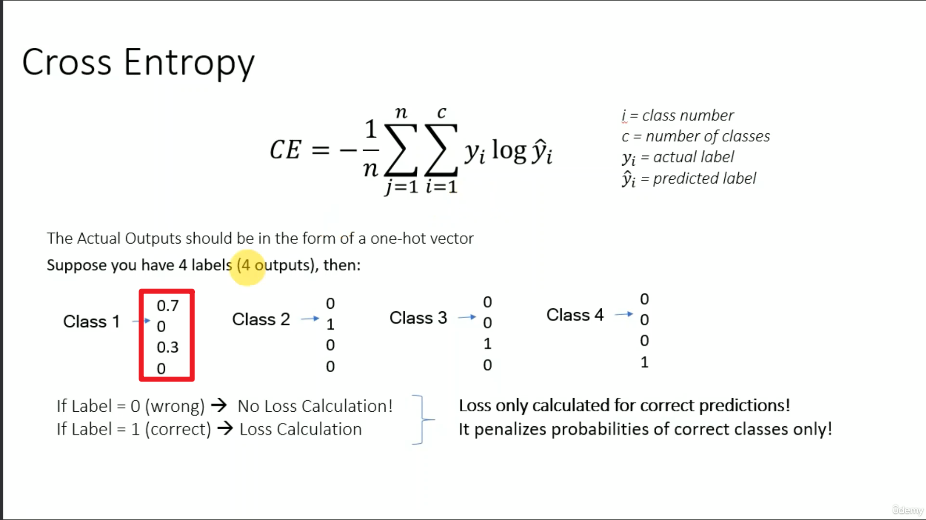

假设你的真实图像的索引是0，所以它的权重是λ，我们说是0.7。假设从批次中随机采样的图像的索引是2，它的权重是0.3。所以这将是你的标签，不再是独热向量。
这将是你的标签。
所以你的交叉熵理论上将如何计算是0.7乘以这个索引的预测加上0.3乘以这个索引的预测。

所以这里的Yi将是0.7而不是1，你将对所有非0的类别求和。所以你将有0.7乘以第一个索引的预测的对数，加上对非0类别的求和，所以加上0.3乘以你在这里得到的逻辑的对数，以及索引号0.3。

### 总结

这段文字解释了在某种情况下如何计算交叉熵损失。具体来说，它描述了当标签不再是独热向量，而是由两个图像的加权组合时，如何计算交叉熵损失。权重λ分别为0.7和0.3，交叉熵损失将根据这两个权重和相应的预测值进行计算。

### 重要信息提取

1. **标签权重**：真实图像的权重为0.7，随机采样图像的权重为0.3。
2. **标签形式**：标签不再是独热向量，而是两个图像的加权组合。这种情况下，标签是一个加权的概率分布
3. **交叉熵计算**：
   - 交叉熵损失 = 0.7 * 第一个索引的预测 + 0.3 * 第二个索引的预测。
   - 对所有非0类别求和。
   - 基于两个图像的预测值和相应的权重
4. **公式**：
   - 交叉熵损失 = 0.7 * log(第一个索引的预测) + 0.3 * log(第二个索引的预测)。
   - 这里的预测值是模型对每个类别的预测概率

### 结论

在这种情况下，交叉熵损失的计算考虑了两个图像的加权组合，而不是传统的独热向量。这种方法可以用于处理标签是多个类别的加权组合的情况，使得模型能够更好地处理复杂的标签分布。

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):

    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def forward(model, mixed_x, y_a, y_b, lam):
    criterion = nn.CrossEntropyLoss()
    pred = model(mixed_x)
    loss = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    return loss

### `mixup_data` 函数

```python
def mixup_data(x, y, alpha=1.0, use_cuda=True):
```
这个函数用于生成混合数据。参数包括：
- `x`：输入数据。
- `y`：标签数据。
- `alpha`：Beta分布的参数，默认值为1.0。
- `use_cuda`：是否使用CUDA，默认值为True。

```python
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
```
这段代码根据 `alpha` 的值生成混合系数 `lam`。如果 `alpha` 大于0，则从Beta分布中采样；否则，`lam` 设置为1。

```python
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
```
这两行代码获取批次大小 `batch_size`，并生成一个随机排列的索引 `index`。

```python
    mixed_x = lam * x + (1 - lam) * x[index, :]
```
这行代码根据混合系数 `lam` 生成混合数据 `mixed_x`。

```python
    y_a, y_b = y, y[index]
```
这行代码生成混合标签 `y_a` 和 `y_b`。

```python
    return mixed_x, y_a, y_b, lam
```
这行代码返回混合数据 `mixed_x`、混合标签 `y_a` 和 `y_b` 以及混合系数 `lam`。

### `forward` 函数

```python
def forward(model, mixed_x, y_a, y_b, lam):
```
这个函数用于前向传播计算损失。参数包括：
- `model`：模型。
- `mixed_x`：混合数据。
- `y_a`：混合标签 `y_a`。
- `y_b`：混合标签 `y_b`。
- `lam`：混合系数。

```python
    criterion = nn.CrossEntropyLoss()
```
这行代码定义交叉熵损失函数 `criterion`。

```python
    pred = model(mixed_x)
```
这行代码将混合数据 `mixed_x` 输入模型，得到预测结果 `pred`。

```python
    loss = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
```
这行代码根据混合系数 `lam` 计算损失 `loss`。

```python
    return loss
```
这行代码返回损失 `loss`。

### 代码优化建议
1. **导入库**：确保在代码的开头导入了所有必要的库。
2. **代码简洁性**：可以将重复的代码块合并，以减少代码行数。
3. **函数调用**：可以将损失函数定义放在函数外部，以提高代码的可读性和复用性。

优化后的代码如下：

```python
import torch
import torch.nn as nn
import numpy as np

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    if use_cuda:
        index = index.cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def forward(model, mixed_x, y_a, y_b, lam, criterion):
    pred = model(mixed_x)
    loss = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    return loss

# 示例用法
# model = ...  # 定义你的模型
# x, y = ...  # 获取输入数据和标签
# criterion = nn.CrossEntropyLoss()
# mixed_x, y_a, y_b, lam = mixup_data(x, y, alpha=1.0, use_cuda=True)
# loss = forward(model, mixed_x, y_a, y_b, lam, criterion)
```

这样可以使代码更加简洁和易读。